In [6]:
# !pip install peft

Defaulting to user installation because normal site-packages is not writeable
  Using cached peft-0.10.0-py3-none-any.whl (199 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 KB 7.9 MB/s eta 0:00:0000:01


In [15]:
# !pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/d6/07/061f97211f942101070a46fecd813a6b1bd83590ed7b07c473cabd707fe7/matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/67/0f/6e5b4879594cd1cbb6a2754d9230937be444f404cf07c360c07a10b36aac/contourpy-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/67/09/e09ee013d9d6f2f006147e5fc2b4d807eb2931f4f890c2d4f711e10391d7/fonttools-4.51.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms
# https://anirbansen2709.medium.com/finetuning-llms-using-lora-77fb02cbbc48
# https://github.com/microsoft/LoRA/tree/main/examples/NLG
# https://github.com/huggingface/peft


In [2]:
import sys
import gc
import math
import re
import string
import numpy as np
import random

import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

sys.path.append('/home/blatova/lca-solvers/')

from data_filters.repo_snapshot_filter_stack import SnapshotFilterStack
from data_classes.datapoint_composed import DatapointComposed
from data_loading.raw_train_dataset_loading import DataLoaderTrainRaw
from data_loading.composer_train_dataset_loading import DataLoaderTrainComposed
from context_composers.context_composer_path_distance import ContextComposerPathDistance
from data_classes.datapoint_composed import DatapointComposed
from datasets import load_dataset

punctuation = string.punctuation
punctuation += "–—‘’“”…"
pattern = re.compile(r'^[a-zA-Z0-9\s' + re.escape(punctuation) + r']*$')

In [3]:
!nvidia-smi

Fri May 31 20:30:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
|  0%   31C    P8              12W / 450W |  21974MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# !kill -9 1694536

In [5]:
# loader = DataLoader(cache_dir="/home/blatova/cache_dir")
# loader = DataLoaderTrainComposed(
#         hf_path='JetBrains-Research/context-py-train',
#         hf_config=None,
#         cache_dir='/mnt/data2/shared-data/lca/hf_cache2/',
#     )
composer = ContextComposerPathDistance()
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base", trust_remote_code=True, torch_dtype=torch.bfloat16).to("cuda:3")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Lora parameters

https://medium.com/@manyi.yim/more-about-loraconfig-from-peft-581cf54643db

https://magazine.sebastianraschka.com/p/practical-tips-for-finetuning-llms

https://abvijaykumar.medium.com/fine-tuning-llm-parameter-efficient-fine-tuning-peft-lora-qlora-part-2-d8e23877ac6f

AdaMix Lora: https://arxiv.org/pdf/2210.17451v1

Lora-based mixture of experts: https://arxiv.org/pdf/2404.15159

I believe the modules you've mentioned: gate_proj, down_proj, up_proj, q_proj, v_proj, k_proj, and o_proj, are all linear layers. So, they should be included in the list for LoRA finetuning to get the best results, that compare to full finetuning.

This is based on the QLoRA paper: "We find that the most critical LoRA hyperparameter is how many LoRA adapters are used in total and that LoRA on all linear transformer block layers is required to match full finetuning performance."

To check which layers are linear, you can load the model with the transformers library in Python and then just print(model). The layers to look for will be labeled Linear or Linear4bit if you load the model in 4-bit. While I can't say this is the only way, it's how I've always done it.

For QLoRA finetuning, I've used my own custom script, so I wrote a function that returns a list to simplify the "finding layers to finetune" process. However, keep in mind, this function will work properly only if the model is loaded in 4-bit using the transformers library:

```def find_target_modules(model):
    # Initialize a Set to Store Unique Layers
    unique_layers = set()
    
    # Iterate Over All Named Modules in the Model
    for name, module in model.named_modules():
        # Check if the Module Type Contains 'Linear4bit'
        if "Linear4bit" in str(type(module)):
            # Extract the Type of the Layer
            layer_type = name.split('.')[-1]
            
            # Add the Layer Type to the Set of Unique Layers
            unique_layers.add(layer_type)

    # Return the Set of Unique Layers Converted to a List
    return list(unique_layers)```
From: https://www.reddit.com/r/LocalLLaMA/comments/15sgg4m/what_modules_should_i_target_when_training_using/

```import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))```


Better result about layers and parameters fine-tuning:

https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms : All linear layers

***Other parameters:***

***Optimizer: Commonly used AdamW***

r=16 => alpha = 16 (That’s why the authors set α to the first r and do not tune it. The default of α is 8.)

***r=32 => alpha = 32***

Dropout rate: 

https://ar5iv.labs.arxiv.org/html/2403.00812

https://arxiv.org/pdf/2403.00812

https://arxiv.org/pdf/2404.09610

Hence, we only introduce the dropping in the latter half of layers in decoder-only models and the apparent performance improvement emerges again.

***Dropout rate: Start without dropout? Usually used 0.1 ***

bias: ???




In [6]:
# ds = load_dataset('JetBrains-Research/context-py-train', 'path_distance_relevant', cache_dir = '/mnt/data2/shared-data/lca/hf_cache2/')
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False, r=32, lora_alpha=32, lora_dropout=0.1, target_modules='all-linear'
)

model_lora = get_peft_model(model, peft_config)
model_lora.print_trainable_parameters()
criterion = CrossEntropyLoss()

trainable params: 29,982,720 || all params: 1,376,454,656 || trainable%: 2.178257007545042


In [7]:
#6000 tokens => OOM
ACCUM_STEPS_NUM = 64
VALIDATION_STEPS = 16
CONTEXT_MAX_LEN_CHARS = 5000
CONTEXT_MAX_LEN_TOKENS = 2000
EMA_PERIOD = 20
EMA_ALPHA = 2/(EMA_PERIOD+1)

In [8]:
optimizer = AdamW(model_lora.parameters(), lr=5e-5, weight_decay=0.01) #added weight decay
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6) #added scheduler

In [9]:
def compose_input_sequence(dp: DatapointComposed, max_len_tokens: int, tokenizer, context_ratio: float = 0.75, 
                           cut_context=True) -> str:
    #here we will probably get a little bit less than a real number of tokens
    approx_max_len_chars = max_len_tokens * 3
    
    if not -1e8 < context_ratio < 1. + 1e8:
        raise ValueError('context_ratio must be between 0 and 1')

    context = dp.context[0]
    completion = dp.completion[0]
    context = '\n'.join([line for line in context.split('\n') if re.match(pattern, line)])
    completion = '\n'.join([line for line in completion.split('\n') if re.match(pattern, line)])

    length_context = int(approx_max_len_chars * context_ratio) + 1
    length_completion = int(approx_max_len_chars * (1 - context_ratio)) + 1

    compl_trim_idx = completion.rfind('\n', 0, length_completion)
    context_trim_idx = context.find('\n', len(context)-length_context, len(context))

    if compl_trim_idx > 0:
        # print("First cut of completion")
        completion_trimmed = completion[:compl_trim_idx]
    else:
        # print("Second cut of completion")
        completion_trimmed = completion[:length_completion]
    if context_trim_idx > 0:
        # print("First cut of context")
        context_trimmed = context[1+context_trim_idx:]
    else:
        # print("Second cut of context")
        context_trimmed = context[-length_context:]
    
    context_len = tokenizer(context_trimmed, return_tensors="pt")['input_ids'].shape[1]
    completion_len = tokenizer(completion_trimmed, return_tensors="pt")['input_ids'].shape[1]
    res_input = tokenizer(context_trimmed + completion_trimmed, return_tensors="pt")
    
    if completion_len>=length_completion:
        print(f"Very strange output: completion_len>=length_completion: {completion_len}>={length_completion}. Skipping")
        print(completion_trimmed)
        return None, None, None
    if context_len>=length_context:
        print(f"Very strange output: context_len>=length_context: {context_len}>={length_context}. Skipping")
        print(completion_trimmed)
        return None, None, None
    if 2*completion_len>=length_completion:
        print(f"Look here: 2*completion_len>=length_completion: 2*{completion_len}>={length_completion}. Not skipping")
        print(completion_trimmed)
    if 2*context_len>=length_context:
        print(f"Look here: 2*context_len>=length_context: 2*{context_len}>={length_context}. Not skipping")
        print(completion_trimmed)
    
        
    # print(f"context_len: {context_len}, completion_len: {completion_len}")
    # # if completion_len>1000:
    #     # print(completion_trimmed)
    # print(f"length_context:{length_context}, length_completion:{length_completion}, len(context_trimmed): {len(context_trimmed)}, len(completion_trimmed): {len(completion_trimmed)}")
    # print(f"context_trim_idx:{context_trim_idx}, len(context): {len(context)}, compl_trim_idx:{compl_trim_idx}, len(completion): {len(completion)}")
    if len(completion_trimmed)<completion_len:
        print(completion_trimmed)
    diff_tokens = 0
   
    if (context_len+completion_len > max_len_tokens):
        diff_tokens = context_len+completion_len - max_len_tokens
        if cut_context:
            res_input['input_ids'] =res_input['input_ids'][:, diff_tokens:]
            res_input['attention_mask'] =res_input['attention_mask'][:,diff_tokens:]
            context_len = context_len - diff_tokens
        else:
            res_input['input_ids'] =res_input['input_ids'][:, :-diff_tokens]
            res_input['attention_mask'] =res_input['attention_mask'][:,:-diff_tokens]
            completion_len = completion_len - diff_tokens
            
    
    return res_input, context_len, completion_len



First cut of completion
First cut of context
context_len: 1222, completion_len: 
length_context:4501, length_completion:1501, len(context_trimmed): 4474, len(completion_trimmed): 1469
context_trim_idx:995525, len(context): 1000000, compl_trim_idx:1469, len(completion): 20843

In [10]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


def live_plot(data1, data2, data3, data4, figsize=(10, 20), title1='Train loss on whole sequence (EMA)', title2='Train loss on completion (EMA)',
             title3='Val loss on whole sequence (EMA)', title4='Val loss on completion (EMA)'):
    clear_output(wait=True)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=figsize)  # Creates 4 subplots vertically aligned

    # Plotting data1 on the first subplot
    ax1.plot(data1, marker='o')
    ax1.set_title(title1)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Plotting data2 on the second subplot
    ax2.plot(data2, marker='o')
    ax2.set_title(title2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Loss')
    ax2.grid(True)

    # Plotting data1 on the first subplot
    ax3.plot(data3, marker='o')
    ax3.set_title(title3)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Loss')
    ax3.grid(True)

    # Plotting data2 on the second subplot
    ax4.plot(data4, marker='o')
    ax4.set_title(title4)
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Loss')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

In [11]:
validation_repos = ['jindongwang__transferlearning', 'wandb__wandb', 'microsoft__nni', 'keras-team__keras-core', 
                    'datadog__integrations-core',
                   'facebookresearch__parlai', 'paddlepaddle__paddledetection', 'facebookresearch__fairseq','mlflow__mlflow',
                    'sony__nnabla-examples','mlrun__mlrun', 'pytorch__audio',
                   'amaranth-lang__amaranth', 'getsentry__sentry-python', 'meltano__sdk', 'skrub-data__skrub','spacetelescope__jwql',
                    'fledge-iot__fledge', 'vivisect__vivisect', 'hexrd__hexrd', 'tensorflow__tfx', 'netenglabs__suzieq','voxel51__fiftyone',
                   'rubisco-sfa__ilamb', 'adrn__gala', 'scverse__scirpy', 'rawpython__remi', 'matchms__matchms', 'python-discord__site', 'lark-parser__lark']

# Filter function to split based on repositories
def is_validation(entry):
    return entry['repo'] in validation_repos

def is_train(entry):
    return entry['repo'] not in validation_repos

def get_new_ema(curr_loss, prev_ema):
    return (curr_loss - prev_ema)*EMA_ALPHA + prev_ema


In [12]:
class HFDataset(Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset
    
    def __len__(self):
        return len(self.hf_dataset)
    
    def __getitem__(self, idx):
        return self.hf_dataset[idx]

dataset = load_dataset("JetBrains-Research/context-py-train", "path_distance_relevant", cache_dir='/mnt/data2/shared-data/lca/hf_cache2/')
# dataset = load_dataset('JetBrains-Research/context-py-train', cache_dir='/mnt/data2/shared-data/lca/hf_cache2/')
val_dataset = dataset['train'].filter(is_validation)
train_dataset = dataset['train'].filter(is_train)
torch_train_dataset = HFDataset(train_dataset)
train_loader = DataLoader(torch_train_dataset, batch_size=1, shuffle=True)

torch_val_dataset = HFDataset(val_dataset)
val_loader = DataLoader(torch_val_dataset, batch_size=1, shuffle=True)
val_loader_iter = iter(val_loader)  # Create an iterator for the validation data

Resolving data files:   0%|          | 0/124 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/124 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [13]:
len(torch_val_dataset)

1288

In [14]:
from collections import Counter
Counter(dataset['train']['repo'])

Counter({'hpcaitech__colossalai': 263,
         'hummingbot__hummingbot': 253,
         'pennylaneai__pennylane': 250,
         'microsoft__archai': 236,
         'open-mmlab__mmpose': 236,
         'jindongwang__transferlearning': 223,
         'keras-team__keras-core': 201,
         'zenml-io__zenml': 181,
         'ethyca__fides': 159,
         'paddlepaddle__paddleseg': 151,
         'open-mmlab__mmdetection': 132,
         'google__uncertainty-baselines': 126,
         'sktime__sktime': 126,
         'itisfoundation__osparc-simcore': 118,
         'awslabs__gluonts': 118,
         'robocorp__robotframework-lsp': 114,
         'microsoft__nni': 112,
         'app-sre__qontract-reconcile': 109,
         'wandb__wandb': 106,
         'aws__sagemaker-python-sdk': 104,
         'autogluon__autogluon': 102,
         'chia-network__chia-blockchain': 101,
         'prefecthq__prefect': 100,
         'lightning-ai__lightning': 97,
         'opentensor__bittensor': 97,
         'twilio__twi

In [15]:
 # hf_path='JetBrains-Research/context-py-train',
#         hf_config=None,
#         cache_dir='/mnt/data2/shared-data/lca/hf_cache2/'

In [16]:
print(val_loader_iter)

In [17]:
def make_validation_step(val_loader_iter):
    model_lora.eval()  
    with torch.no_grad():
        total_val_loss = 0
        total_val_tokens = 0
        val_steps_count = 0
        curr_val_loss_whole_input=[]
        curr_val_loss_completion=[]

        # read datapoint VALIDATION_STEPS number of times
        while val_steps_count < VALIDATION_STEPS:
            try:
                val_hf_dp = next(val_loader_iter)
            except StopIteration:
                val_loader_iter = iter(val_loader)  # Reset the iterator if all data has been used
                val_hf_dp = next(val_loader_iter)

            val_dp = DatapointComposed.from_hf_datapoint(val_hf_dp)
            val_inputs, val_context_len, val_completion_len = compose_input_sequence(val_dp, CONTEXT_MAX_LEN_TOKENS, tokenizer, 0.75)
            if val_inputs is not None:
                val_inputs = val_inputs.to(model_lora.device)
                val_outputs = model_lora.forward(**val_inputs)
                val_logits_size = val_outputs['logits'].size(-1)
                val_loss_completion = criterion(val_outputs['logits'].view(-1, val_outputs['logits'].size(-1))[-val_completion_len:-1, :], val_inputs['input_ids'].view(-1)[-val_completion_len+1:])
                val_detached_logits = val_outputs['logits'].detach()
                
                # for 0 output logit we have corresponding 1st input
                val_loss_whole_input = criterion(val_detached_logits.view(-1, val_detached_logits.size(-1))[:-1, :], val_inputs['input_ids'].view(-1)[1:]) 
                curr_val_loss_whole_input.append(val_loss_whole_input.item())
                curr_val_loss_completion.append(val_loss_completion.item())
                val_steps_count=val_steps_count+1
                
        #calculate losses
        val_losses_whole_input.append(sum(curr_val_loss_whole_input)/len(curr_val_loss_whole_input))
        val_losses_completion.append(sum(curr_val_loss_completion)/len(curr_val_loss_completion))

        if len(val_losses_whole_input)>EMA_PERIOD:
            val_loss_whole_input_ema.append(get_new_ema(val_losses_whole_input[-1],val_loss_whole_input_ema[-1]))
            val_loss_completion_ema.append(get_new_ema(val_losses_completion[-1],val_loss_completion_ema[-1]))
            
        elif len(val_losses_whole_input)==EMA_PERIOD:
            val_loss_whole_input_ema.append(np.mean(val_losses_whole_input))
            val_loss_completion_ema.append(np.mean(val_losses_completion))
    
    model_lora.train()  # Set the model back to train mode

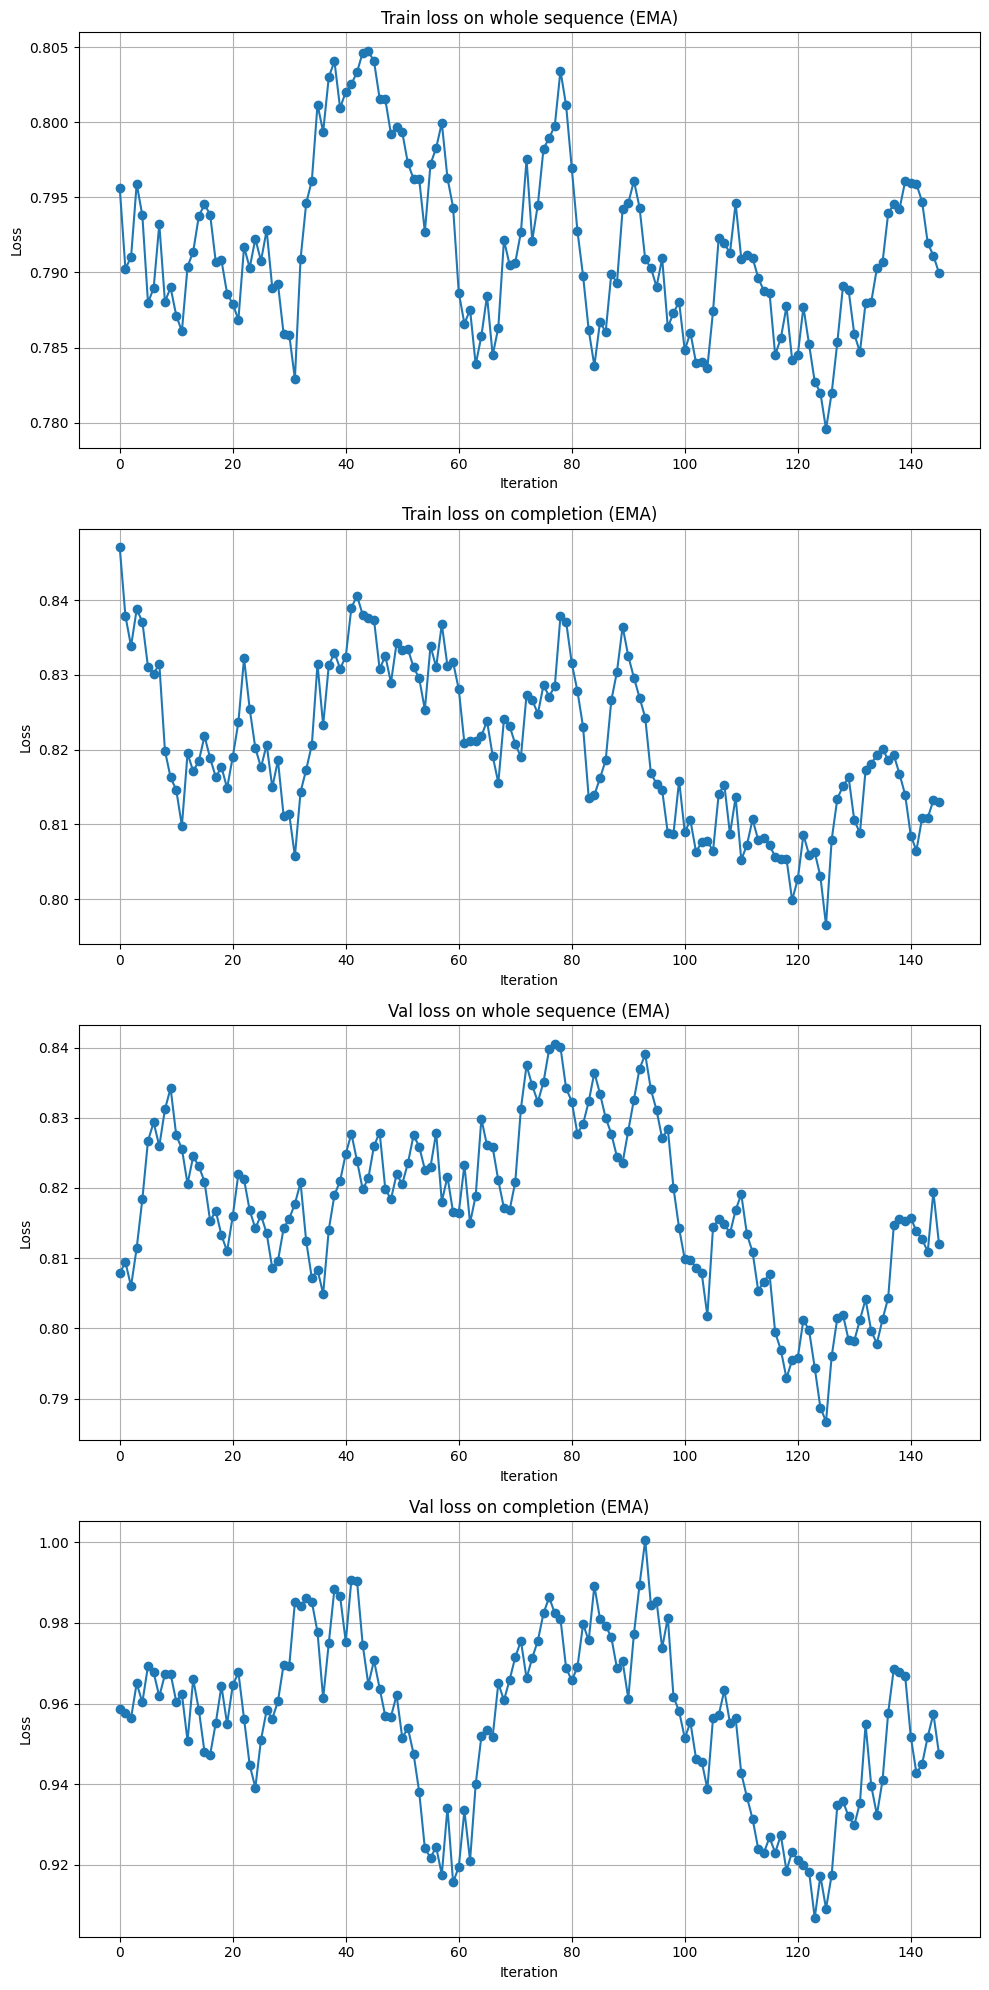

Plotted: 10560 steps
Look here: 2*completion_len>=length_completion: 2*802>=1501. Not skipping
# IMPORTATION STANDARD
import os
from collections import namedtuple

# IMPORTATION THIRDPARTY
import pandas as pd
import pytest

# IMPORTATION INTERNAL
from gamestonk_terminal.stocks.options import options_controller

# pylint: disable=E1101
# pylint: disable=W0603
# pylint: disable=E1111

EXPIRY_DATES = [
    "2022-01-07",
    "2022-01-14",
    "2022-01-21",
    "2022-01-28",
    "2022-02-04",
    "2022-02-18",
    "2022-03-18",
    "2022-04-14",
    "2022-05-20",
    "2022-06-17",
    "2022-07-15",
    "2022-09-16",
    "2023-01-20",
    "2023-03-17",
    "2023-06-16",
    "2023-09-15",
    "2024-01-19",
]

CALLS = pd.DataFrame(
    data={
        "contractSymbol": ["TSLA211231C00200000", "TSLA211231C00250000"],
        "lastTradeDate": [
            pd.Timestamp("2021-12-29 15:01:33"),
            pd.Timestamp("2021-12-10 15:09:36"),
        ],
        "strike": [200.0, 250.0],
        "la

KeyboardInterrupt: 

In [18]:
torch.cuda.empty_cache()
total_whole_input_loss = 0
total_completion_loss = 0
total_tokens = 0
total_completion_tokens = 0
train_losses_whole_input = []
curr_train_loss_whole_input = []
train_losses_completion = []
curr_train_loss_completion = []

val_losses_whole_input = []
val_losses_completion = []


train_loss_whole_input_ema = []
train_loss_completion_ema = []
val_loss_whole_input_ema = []
val_loss_completion_ema = []

for idx, hf_dp in enumerate(train_loader):
    # torch.cuda.empty_cache()
    # if idx > 20:
    #     break

    dp = DatapointComposed.from_hf_datapoint(hf_dp)
    inputs, context_len, completion_len = compose_input_sequence(dp, CONTEXT_MAX_LEN_TOKENS, tokenizer, 0.75)
    if inputs is not None:
        assert abs(completion_len+context_len-inputs['input_ids'].shape[1])<2
        # full_len = inputs['input_ids'].shape[1]
        inputs = inputs.to(model_lora.device)
        outputs = model_lora.forward(**inputs)
        logits_size = outputs['logits'].size(-1)
        loss_completion = criterion(outputs['logits'].view(-1, outputs['logits'].size(-1))[-completion_len:-1, :], inputs['input_ids'].view(-1)[-completion_len+1:])
        
        loss_completion.backward()
        detached_logits = outputs['logits'].detach()
        
        # for 0 output logit we have corresponding 1st input
        loss_whole_input = criterion(detached_logits.view(-1, detached_logits.size(-1))[:-1, :], inputs['input_ids'].view(-1)[1:]) 
        
        # calculate losses and backprop
        if (idx+1) % ACCUM_STEPS_NUM ==0:
            train_losses_whole_input.append(sum(curr_train_loss_whole_input)/len(curr_train_loss_whole_input))
            train_losses_completion.append(sum(curr_train_loss_completion)/len(curr_train_loss_completion))
            
            if len(train_losses_whole_input)>EMA_PERIOD:
                    train_loss_whole_input_ema.append(get_new_ema(train_losses_whole_input[-1],train_loss_whole_input_ema[-1]))
                    train_loss_completion_ema.append(get_new_ema(train_losses_completion[-1],train_loss_completion_ema[-1]))
            elif len(train_losses_whole_input)==EMA_PERIOD:
                train_loss_whole_input_ema.append(np.mean(train_losses_whole_input))
                train_loss_completion_ema.append(np.mean(train_losses_completion))

            curr_train_loss_whole_input = []
            curr_train_loss_completion=[]
            for param in model_lora.parameters():
                if param.requires_grad:
                    if param.grad is not None:
                        param.grad /= ACCUM_STEPS_NUM
            
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

        #we could set some other parameter here
        if (idx+1) % ACCUM_STEPS_NUM ==0:
            make_validation_step(val_loader_iter)
            
    
        if (idx+1) % (ACCUM_STEPS_NUM*5) ==0:
            if (len(train_loss_whole_input_ema)>2) and (len(val_loss_whole_input_ema)>2):
                live_plot(train_loss_whole_input_ema, train_loss_completion_ema, val_loss_whole_input_ema, val_loss_completion_ema)
                print(f"Plotted: {(idx+1)} steps")

            
        
        curr_train_loss_whole_input.append(loss_whole_input.item())
        curr_train_loss_completion.append(loss_completion.item())
        total_whole_input_loss += loss_whole_input.item() * (inputs['input_ids'].size(0)-1)  # Accumulate scaled loss
        total_completion_loss += loss_completion.item() * (completion_len -1)  # Accumulate scaled loss
        total_tokens += len(inputs['input_ids']) - 1  # Count tokens processed
        total_completion_tokens += completion_len - 1

        

        
        
avg_loss = total_whole_input_loss / total_tokens
perplexity = math.exp(avg_loss)  # Calculate perplexity as exp of the average loss

avg_completion_loss = total_completion_loss / total_completion_tokens
perplexity = math.exp(avg_completion_loss)




    

In [21]:
print(val_losses_whole_input)
print(val_losses_completion)

[]
[]


First cut of completion
First cut of context
context_len: 1222, completion_len: 2548
length_context:4501, length_completion:1501, len(context_trimmed): 4474, len(completion_trimmed): 1469
context_trim_idx:995525, len(context): 1000000, compl_trim_idx:1469, len(completion): 20843

In [31]:
inputs

{'input_ids': tensor([[207, 154,  99,  ...,  99,  94, 950]], device='cuda:3'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:3')}

In [ ]:
# print(len(train_losses))

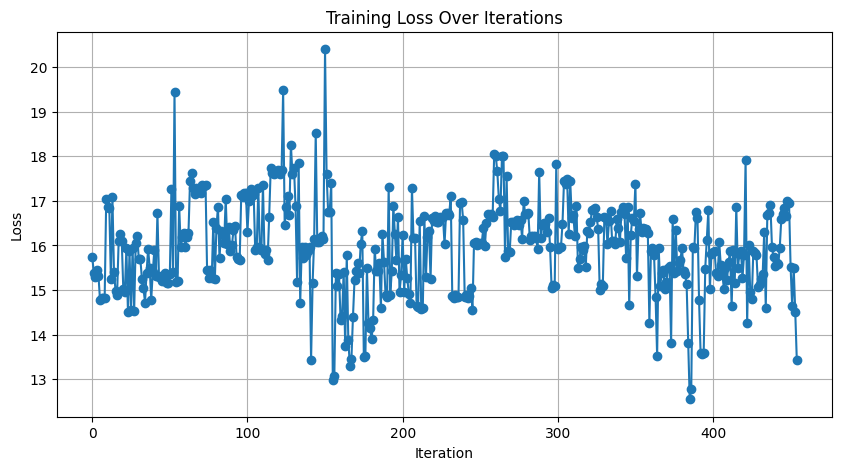

In [10]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, marker='o')
# plt.title('Training Loss Over Iterations')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.show()